In [287]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime
from numba import jit
from lightgbm import LGBMRegressor
from multiprocessing import Pool
from sklearn.model_selection import TimeSeriesSplit

import pickle
import gc

from tqdm import tqdm

n_fold = 10
group_gap = 31
seed = 42


TRAIN_MARKET_PATH = '~/OneDrive - connect.hku.hk/Algo_trading/first_round_train_market_data.csv'
TRAIN_FUNADMENTAL_PATH = '~/OneDrive - connect.hku.hk/Algo_trading/first_round_train_fundamental_data.csv'
TRAIN_RETURN_PATH = '~/OneDrive - connect.hku.hk/Algo_trading/first_round_train_return_data.csv'

TEST_MARKET_PATH = '~/OneDrive - connect.hku.hk/Algo_trading/first_round_test_market_data.csv'
TEST_FUNADMENTAL_PATH = '~/OneDrive - connect.hku.hk/Algo_trading/first_round_test_fundamental_data.csv'


pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 350)

In [288]:
df_train_market = pd.read_csv(TRAIN_MARKET_PATH)
df_train_return = pd.read_csv(TRAIN_RETURN_PATH)
df_train_fundamental = pd.read_csv(TRAIN_FUNADMENTAL_PATH)

df_test_market = pd.read_csv(TEST_MARKET_PATH)
df_test_fundamental = pd.read_csv(TEST_FUNADMENTAL_PATH)


In [289]:
df_train_market

,date_time,open,close,high,low,volume,money
0,s0d1p1,25.0164,24.9557,25.1378,24.9436,642243.0,1.610060e+07
1,s1d1p1,16.3256,16.3499,16.4106,16.3256,15552.0,2.540301e+05
2,s2d1p1,9.2006,9.1763,9.2006,9.1521,396647.0,3.638304e+06
...,...,...,...,...,...,...,...
2699997,s51d1000p50,3.5200,3.5200,3.5200,3.5200,284775.0,1.002944e+06
2699998,s52d1000p50,28.4151,28.4151,28.4151,28.4151,22654.0,6.437413e+05
2699999,s53d1000p50,9.8803,9.9046,9.9046,9.8803,139460.0,1.380952e+06


In [290]:
#train_index = np.arange(0, 53892)
#test_index = np.arange(0, 37800)

In [291]:
'''
# calculate every day open miuns last day close
Mark = df_train_market

Mark_time = Mark['date_time'].str.split('p', expand=True)
Mark_time.columns = ['date', 'time']
Mark = pd.concat([Mark, Mark_time], axis=1)
Mark_open = Mark[Mark['time'] == '1']
Mark_close = Mark[Mark['time'] == '50']

Mark_open = Mark_open[54:53892]
Mark_open.reset_index(drop=True, inplace=True)
Mark_close = Mark_close[:53838]
Mark_close.reset_index(drop=True, inplace=True)

diff_p_out = Mark_open['open'] - Mark_close['close']

df0 = pd.DataFrame(np.zeros((54,1)))
diff_p_out = pd.concat([df0,diff_p_out],axis=0)
diff_p_out.reset_index(drop=True, inplace=True)
diff_p_out.columns = ['diff_p_out']
'''

"\n# calculate every day open miuns last day close\nMark = df_train_market\n\nMark_time = Mark['date_time'].str.split('p', expand=True)\nMark_time.columns = ['date', 'time']\nMark = pd.concat([Mark, Mark_time], axis=1)\nMark_open = Mark[Mark['time'] == '1']\nMark_close = Mark[Mark['time'] == '50']\n\nMark_open = Mark_open[54:53892]\nMark_open.reset_index(drop=True, inplace=True)\nMark_close = Mark_close[:53838]\nMark_close.reset_index(drop=True, inplace=True)\n\ndiff_p_out = Mark_open['open'] - Mark_close['close']\n\ndf0 = pd.DataFrame(np.zeros((54,1)))\ndiff_p_out = pd.concat([df0,diff_p_out],axis=0)\ndiff_p_out.reset_index(drop=True, inplace=True)\ndiff_p_out.columns = ['diff_p_out']\n"

In [292]:
'''
# calculate same thing for test data
Mark = df_test_market

Mark_time = Mark['date_time'].str.split('p', expand=True)
Mark_time.columns = ['date', 'time']
Mark = pd.concat([Mark, Mark_time], axis=1)
Mark_open = Mark[Mark['time'] == '1']
Mark_close = Mark[Mark['time'] == '50']

Mark_open = Mark_open[54:37800]
Mark_open.reset_index(drop=True, inplace=True)
Mark_close = Mark_close[:37746]
Mark_close.reset_index(drop=True, inplace=True)

diff_p_out_test = Mark_open['open'] - Mark_close['close']

df0 = pd.DataFrame(np.zeros((54,1)))
diff_p_out_test = pd.concat([df0,diff_p_out_test],axis=0)
diff_p_out_test.reset_index(drop=True, inplace=True)
diff_p_out_test.columns = ['diff_p_out']
'''

"\n# calculate same thing for test data\nMark = df_test_market\n\nMark_time = Mark['date_time'].str.split('p', expand=True)\nMark_time.columns = ['date', 'time']\nMark = pd.concat([Mark, Mark_time], axis=1)\nMark_open = Mark[Mark['time'] == '1']\nMark_close = Mark[Mark['time'] == '50']\n\nMark_open = Mark_open[54:37800]\nMark_open.reset_index(drop=True, inplace=True)\nMark_close = Mark_close[:37746]\nMark_close.reset_index(drop=True, inplace=True)\n\ndiff_p_out_test = Mark_open['open'] - Mark_close['close']\n\ndf0 = pd.DataFrame(np.zeros((54,1)))\ndiff_p_out_test = pd.concat([df0,diff_p_out_test],axis=0)\ndiff_p_out_test.reset_index(drop=True, inplace=True)\ndiff_p_out_test.columns = ['diff_p_out']\n"

In [293]:
'''
# calculate every day close minus open
Mark = df_train_market

Mark_time = Mark['date_time'].str.split('p', expand=True)
Mark_time.columns = ['date', 'time']
Mark = pd.concat([Mark, Mark_time], axis=1)
Mark_open = Mark[Mark['time'] == '1']
Mark_close = Mark[Mark['time'] == '50']

Mark_open = Mark_open[:53892]
Mark_open.index = train_index

Mark_close = Mark_close[:53892]
Mark_close.index = train_index

diff_p_in = Mark_close.close - Mark_open.open
diff_p_in
'''

"\n# calculate every day close minus open\nMark = df_train_market\n\nMark_time = Mark['date_time'].str.split('p', expand=True)\nMark_time.columns = ['date', 'time']\nMark = pd.concat([Mark, Mark_time], axis=1)\nMark_open = Mark[Mark['time'] == '1']\nMark_close = Mark[Mark['time'] == '50']\n\nMark_open = Mark_open[:53892]\nMark_open.index = train_index\n\nMark_close = Mark_close[:53892]\nMark_close.index = train_index\n\ndiff_p_in = Mark_close.close - Mark_open.open\ndiff_p_in\n"

In [294]:
'''
# do the same calculation for test data
Mark = df_test_market

Mark_time = Mark['date_time'].str.split('p', expand=True)
Mark_time.columns = ['date', 'time']
Mark = pd.concat([Mark, Mark_time], axis=1)
Mark_open = Mark[Mark['time'] == '1']
Mark_close = Mark[Mark['time'] == '50']

Mark_open = Mark_open[:37800]
Mark_open.index = test_index

Mark_close = Mark_close[:37800]
Mark_close.index = test_index

diff_p_in_test = Mark_close.close - Mark_open.open
diff_p_in_test
'''

"\n# do the same calculation for test data\nMark = df_test_market\n\nMark_time = Mark['date_time'].str.split('p', expand=True)\nMark_time.columns = ['date', 'time']\nMark = pd.concat([Mark, Mark_time], axis=1)\nMark_open = Mark[Mark['time'] == '1']\nMark_close = Mark[Mark['time'] == '50']\n\nMark_open = Mark_open[:37800]\nMark_open.index = test_index\n\nMark_close = Mark_close[:37800]\nMark_close.index = test_index\n\ndiff_p_in_test = Mark_close.close - Mark_open.open\ndiff_p_in_test\n"

In [295]:
def split_time(x):
    df1 = x['date_time'].str.split('d', expand=True)
    df1.columns=['code','s']
    code = df1['code']
    df1 = df1['s'].str.split('p', expand=True)
    df1.columns=['day','time_step']
    df2 = x['date_time'].str.rsplit('p', expand=True)
    df2.columns=['day_s','s']
    df1['day_s'] = df2['day_s']
    df1['code'] = code
    x = pd.concat([x,df1],axis=1)
    
    return x

df_train_market = split_time(df_train_market)
df = pd.merge(df_train_fundamental,df_train_market, left_on='date_time',right_on='day_s')  
df = pd.merge(df,df_train_return, left_on='day_s',right_on='date_time')  

df_test_market = split_time(df_test_market)
test = pd.merge(df_test_fundamental,df_test_market, left_on='date_time',right_on='day_s')  


In [296]:
df = df.drop_duplicates(subset='day_s', keep='last').reset_index(drop=True)
test = test.drop_duplicates(subset='day_s', keep='last').reset_index(drop=True)


In [297]:
df

,date_time_x,turnoverRatio,transactionAmount,pe_ttm,pe,pb,ps,pcf,date_time_y,open,close,high,low,volume,money,day,time_step,day_s,code,date_time,return
0,s0d1,3.6794,17229.0,34.4425,32.3029,4.9425,3.8180,-578.7700,s0d1p50,24.3731,24.3852,24.3852,24.3731,170476.0,4.157520e+06,1,50,s0d1,s0,s0d1,-0.026877
1,s1d1,2.5150,3706.0,28.9934,27.2726,5.0552,3.0484,23.8260,s1d1p50,16.1557,16.1314,16.2771,16.1071,70944.0,1.146780e+06,1,50,s1d1,s1,s1d1,-0.052674
2,s2d1,1.2858,5136.0,42.9352,41.9279,4.8083,4.1392,-58.2185,s2d1p50,9.0307,9.0307,9.0307,9.0307,84204.0,7.603632e+05,1,50,s2d1,s2,s2d1,-0.002691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53889,s51d998,1.1501,5179.0,14.5922,14.5922,1.4130,0.7009,19.5205,s51d998p50,3.7142,3.7142,3.7142,3.7142,189327.0,7.036010e+05,998,50,s51d998,s51,s51d998,-0.052286
53890,s52d998,0.5684,7558.0,28.9922,28.9922,5.7855,3.7150,-582.4621,s52d998p50,28.8642,28.8642,28.8642,28.8642,59609.0,1.720926e+06,998,50,s52d998,s52,s52d998,-0.015559
53891,s53d998,1.2933,9681.0,10.6513,10.6513,1.9956,0.4073,134.5467,s53d998p50,9.9410,9.9410,9.9410,9.9410,185080.0,1.838895e+06,998,50,s53d998,s53,s53d998,-0.003662


In [298]:
test

,date_time_x,turnoverRatio,transactionAmount,pe_ttm,pe,pb,ps,pcf,date_time_y,open,close,high,low,volume,money,day,time_step,day_s,code
0,s0d1001,1.1718,9290.0,63.6900,63.6900,1.6398,1.5477,-40.9539,s0d1001p50,12.3929,12.3929,12.3929,12.3929,193641.0,2.398687e+06,1001,50,s0d1001,s0
1,s1d1001,0.5027,9539.0,33.1536,33.1536,5.2277,3.3677,124.7176,s1d1001p50,30.2479,30.2964,30.2964,30.2479,44257.0,1.340836e+06,1001,50,s1d1001,s1
2,s2d1001,0.5060,9765.0,36.6197,36.6197,6.0413,4.4686,33.3814,s2d1001p50,23.8148,23.8148,23.8148,23.8148,33383.0,7.948739e+05,1001,50,s2d1001,s2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37797,s51d1700,0.7608,14507.0,27.2893,26.4071,2.8152,1.5624,105.1597,s51d1700p50,9.9896,9.9896,9.9896,9.9896,87100.0,8.700919e+05,1700,50,s51d1700,s51
37798,s52d1700,0.7141,21682.0,44.0500,44.6896,8.9903,5.9904,521.3693,s52d1700p50,71.9055,71.9662,71.9662,71.9055,126493.0,9.103476e+06,1700,50,s52d1700,s52
37799,s53d1700,0.5977,11139.0,14.6032,17.7694,2.1421,0.3288,13.3351,s53d1700p50,16.1193,16.1071,16.1193,16.1071,74900.0,1.205762e+06,1700,50,s53d1700,s53


In [299]:
df = df.drop(['pe','ps','pcf','pe_ttm'],axis=1)

In [300]:
test = test.drop(['pe','ps','pcf','pe_ttm'],axis=1)

In [301]:
# get the one day difference of pb
second_day_pb = df.pb[54:]
first_day_pb = df.pb[:-54]
first_day_pb.index = second_day_pb.index
diff_pb = second_day_pb - first_day_pb
df0 = pd.DataFrame(np.zeros((54,1)))
diff_pb = pd.concat([df0,diff_pb],axis=0)
diff_pb.columns = ['diff_pb']
df = pd.concat([df,diff_pb],axis=1)

In [302]:
# do the same thing for test
second_day_pb = test.pb[54:]
first_day_pb = test.pb[:-54]
first_day_pb.index = second_day_pb.index
diff_pb = second_day_pb - first_day_pb
df0 = pd.DataFrame(np.zeros((54,1)))
diff_pb = pd.concat([df0,diff_pb],axis=0)
diff_pb.columns = ['diff_pb']
test = pd.concat([test,diff_pb],axis=1)

In [303]:
'''
second_day_volume = df.volume[54:]
first_day_volume = df.volume[:-54]
first_day_volume.index = second_day_volume.index
one_day_volume_change = second_day_volume - first_day_volume
df0 = pd.DataFrame(np.zeros((54,1)))
one_day_volume_change = pd.concat([df0,one_day_volume_change],axis=0)
one_day_volume_change.columns = ['one_day_volume_change']
df = pd.concat([df,one_day_volume_change],axis=1)
'''


"\nsecond_day_volume = df.volume[54:]\nfirst_day_volume = df.volume[:-54]\nfirst_day_volume.index = second_day_volume.index\none_day_volume_change = second_day_volume - first_day_volume\ndf0 = pd.DataFrame(np.zeros((54,1)))\none_day_volume_change = pd.concat([df0,one_day_volume_change],axis=0)\none_day_volume_change.columns = ['one_day_volume_change']\ndf = pd.concat([df,one_day_volume_change],axis=1)\n"

In [304]:
'''
second_day_volume = test.volume[54:]
first_day_volume = test.volume[:-54]
first_day_volume.index = second_day_volume.index
one_day_volume_change = second_day_volume - first_day_volume
df0 = pd.DataFrame(np.zeros((54,1)))
one_day_volume_change = pd.concat([df0,one_day_volume_change],axis=0)
one_day_volume_change.columns = ['one_day_volume_change']
test = pd.concat([test,one_day_volume_change],axis=1)
'''

"\nsecond_day_volume = test.volume[54:]\nfirst_day_volume = test.volume[:-54]\nfirst_day_volume.index = second_day_volume.index\none_day_volume_change = second_day_volume - first_day_volume\ndf0 = pd.DataFrame(np.zeros((54,1)))\none_day_volume_change = pd.concat([df0,one_day_volume_change],axis=0)\none_day_volume_change.columns = ['one_day_volume_change']\ntest = pd.concat([test,one_day_volume_change],axis=1)\n"

In [305]:
df

,date_time_x,turnoverRatio,transactionAmount,pb,date_time_y,open,close,high,low,volume,money,day,time_step,day_s,code,date_time,return,diff_pb
0,s0d1,3.6794,17229.0,4.9425,s0d1p50,24.3731,24.3852,24.3852,24.3731,170476.0,4.157520e+06,1,50,s0d1,s0,s0d1,-0.026877,0.0000
1,s1d1,2.5150,3706.0,5.0552,s1d1p50,16.1557,16.1314,16.2771,16.1071,70944.0,1.146780e+06,1,50,s1d1,s1,s1d1,-0.052674,0.0000
2,s2d1,1.2858,5136.0,4.8083,s2d1p50,9.0307,9.0307,9.0307,9.0307,84204.0,7.603632e+05,1,50,s2d1,s2,s2d1,-0.002691,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53889,s51d998,1.1501,5179.0,1.4130,s51d998p50,3.7142,3.7142,3.7142,3.7142,189327.0,7.036010e+05,998,50,s51d998,s51,s51d998,-0.052286,-0.0576
53890,s52d998,0.5684,7558.0,5.7855,s52d998p50,28.8642,28.8642,28.8642,28.8642,59609.0,1.720926e+06,998,50,s52d998,s52,s52d998,-0.015559,0.0257
53891,s53d998,1.2933,9681.0,1.9956,s53d998p50,9.9410,9.9410,9.9410,9.9410,185080.0,1.838895e+06,998,50,s53d998,s53,s53d998,-0.003662,0.0382


In [306]:
test

,date_time_x,turnoverRatio,transactionAmount,pb,date_time_y,open,close,high,low,volume,money,day,time_step,day_s,code,diff_pb
0,s0d1001,1.1718,9290.0,1.6398,s0d1001p50,12.3929,12.3929,12.3929,12.3929,193641.0,2.398687e+06,1001,50,s0d1001,s0,0.0000
1,s1d1001,0.5027,9539.0,5.2277,s1d1001p50,30.2479,30.2964,30.2964,30.2479,44257.0,1.340836e+06,1001,50,s1d1001,s1,0.0000
2,s2d1001,0.5060,9765.0,6.0413,s2d1001p50,23.8148,23.8148,23.8148,23.8148,33383.0,7.948739e+05,1001,50,s2d1001,s2,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37797,s51d1700,0.7608,14507.0,2.8152,s51d1700p50,9.9896,9.9896,9.9896,9.9896,87100.0,8.700919e+05,1700,50,s51d1700,s51,0.0206
37798,s52d1700,0.7141,21682.0,8.9903,s52d1700p50,71.9055,71.9662,71.9662,71.9055,126493.0,9.103476e+06,1700,50,s52d1700,s52,0.1348
37799,s53d1700,0.5977,11139.0,2.1421,s53d1700p50,16.1193,16.1071,16.1193,16.1071,74900.0,1.205762e+06,1700,50,s53d1700,s53,0.0307


In [307]:
'''
# concat the diff_p_out
df = pd.concat([df,diff_p_out],axis=1)
test = pd.concat([test,diff_p_out_test],axis=1)
'''

'\n# concat the diff_p_out\ndf = pd.concat([df,diff_p_out],axis=1)\ntest = pd.concat([test,diff_p_out_test],axis=1)\n'

In [308]:
'''
# concat the diff_p_in to train data
df = pd.concat([df,diff_p_in],axis=1)

# concat the diff_p_in to test data
test = pd.concat([test,diff_p_in_test],axis=1)
'''

'\n# concat the diff_p_in to train data\ndf = pd.concat([df,diff_p_in],axis=1)\n\n# concat the diff_p_in to test data\ntest = pd.concat([test,diff_p_in_test],axis=1)\n'

In [309]:
df

,date_time_x,turnoverRatio,transactionAmount,pb,date_time_y,open,close,high,low,volume,money,day,time_step,day_s,code,date_time,return,diff_pb
0,s0d1,3.6794,17229.0,4.9425,s0d1p50,24.3731,24.3852,24.3852,24.3731,170476.0,4.157520e+06,1,50,s0d1,s0,s0d1,-0.026877,0.0000
1,s1d1,2.5150,3706.0,5.0552,s1d1p50,16.1557,16.1314,16.2771,16.1071,70944.0,1.146780e+06,1,50,s1d1,s1,s1d1,-0.052674,0.0000
2,s2d1,1.2858,5136.0,4.8083,s2d1p50,9.0307,9.0307,9.0307,9.0307,84204.0,7.603632e+05,1,50,s2d1,s2,s2d1,-0.002691,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53889,s51d998,1.1501,5179.0,1.4130,s51d998p50,3.7142,3.7142,3.7142,3.7142,189327.0,7.036010e+05,998,50,s51d998,s51,s51d998,-0.052286,-0.0576
53890,s52d998,0.5684,7558.0,5.7855,s52d998p50,28.8642,28.8642,28.8642,28.8642,59609.0,1.720926e+06,998,50,s52d998,s52,s52d998,-0.015559,0.0257
53891,s53d998,1.2933,9681.0,1.9956,s53d998p50,9.9410,9.9410,9.9410,9.9410,185080.0,1.838895e+06,998,50,s53d998,s53,s53d998,-0.003662,0.0382


In [310]:
test

,date_time_x,turnoverRatio,transactionAmount,pb,date_time_y,open,close,high,low,volume,money,day,time_step,day_s,code,diff_pb
0,s0d1001,1.1718,9290.0,1.6398,s0d1001p50,12.3929,12.3929,12.3929,12.3929,193641.0,2.398687e+06,1001,50,s0d1001,s0,0.0000
1,s1d1001,0.5027,9539.0,5.2277,s1d1001p50,30.2479,30.2964,30.2964,30.2479,44257.0,1.340836e+06,1001,50,s1d1001,s1,0.0000
2,s2d1001,0.5060,9765.0,6.0413,s2d1001p50,23.8148,23.8148,23.8148,23.8148,33383.0,7.948739e+05,1001,50,s2d1001,s2,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37797,s51d1700,0.7608,14507.0,2.8152,s51d1700p50,9.9896,9.9896,9.9896,9.9896,87100.0,8.700919e+05,1700,50,s51d1700,s51,0.0206
37798,s52d1700,0.7141,21682.0,8.9903,s52d1700p50,71.9055,71.9662,71.9662,71.9055,126493.0,9.103476e+06,1700,50,s52d1700,s52,0.1348
37799,s53d1700,0.5977,11139.0,2.1421,s53d1700p50,16.1193,16.1071,16.1193,16.1071,74900.0,1.205762e+06,1700,50,s53d1700,s53,0.0307


In [311]:
def correlation(a, train_data):
    
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [335]:
df

,date_time_x,turnoverRatio,transactionAmount,pb,date_time_y,open,close,high,low,volume,money,day,time_step,day_s,code,date_time,return,diff_pb
0,s0d1,3.6794,17229.0,4.9425,s0d1p50,24.3731,24.3852,24.3852,24.3731,170476.0,4.157520e+06,1,50,s0d1,s0,s0d1,-0.026877,0.0000
1,s1d1,2.5150,3706.0,5.0552,s1d1p50,16.1557,16.1314,16.2771,16.1071,70944.0,1.146780e+06,1,50,s1d1,s1,s1d1,-0.052674,0.0000
2,s2d1,1.2858,5136.0,4.8083,s2d1p50,9.0307,9.0307,9.0307,9.0307,84204.0,7.603632e+05,1,50,s2d1,s2,s2d1,-0.002691,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53889,s51d998,1.1501,5179.0,1.4130,s51d998p50,3.7142,3.7142,3.7142,3.7142,189327.0,7.036010e+05,998,50,s51d998,s51,s51d998,-0.052286,-0.0576
53890,s52d998,0.5684,7558.0,5.7855,s52d998p50,28.8642,28.8642,28.8642,28.8642,59609.0,1.720926e+06,998,50,s52d998,s52,s52d998,-0.015559,0.0257
53891,s53d998,1.2933,9681.0,1.9956,s53d998p50,9.9410,9.9410,9.9410,9.9410,185080.0,1.838895e+06,998,50,s53d998,s53,s53d998,-0.003662,0.0382


In [336]:
def train_and_evaluate(train,test):
    # Hyperparammeters (just basic)
    params = {
      'objective': 'mape',  
      'boosting_type': 'gbdt',
      'n_jobs': -1,
      'verbose': -1
    }
    
    # Split features and target
    x = train[[i for i in df.columns if i not in ['date_time_x', 'date_time_y', 'day', 'time_step', 'day_s', 'code', 'date_time','return']]]
    y = train['return']
    
    x_test = test[[i for i in df.columns if i not in ['date_time_x', 'date_time_y', 'day', 'time_step', 'day_s', 'code', 'date_time','return']]]

    oof_predictions = np.zeros(x.shape[0])
    test_predictions = np.zeros(x_test.shape[0])
    scores = []

    # Create a KFold object
    gkf = TimeSeriesSplit(n_splits=n_fold,gap=group_gap)
    for fold, (trn_ind, val_ind) in enumerate(gkf.split(train['day'].values)):
    
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]

        train_dataset = lgb.Dataset(x_train, y_train)
        val_dataset = lgb.Dataset(x_val, y_val)
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 200, 
                          early_stopping_rounds = 20, 
                          verbose_eval = False,
                          feval = correlation)
        # Add predictions to the out of folds array
        
        oof_predictions[val_ind] = model.predict(x_val)
        
        rmspe_score = corr_score(y_val,oof_predictions[val_ind])
        print(f'Our out of folds corr_score is {rmspe_score}')
        scores.append(rmspe_score)
        test_predictions += model.predict(x_test) 
        
    rmspe_score = corr_score(y, oof_predictions)
    print(scores)
    print(f'Our out of folds corr score is {rmspe_score}')
    
    # Return test predictions
    return test_predictions

In [337]:
test_predictions = train_and_evaluate(df,test)


Training fold 1
Our out of folds corr_score is -0.0007220549905776158
Training fold 2


/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Our out of folds corr_score is 0.04282369265833181
Training fold 3
Our out of folds corr_score is 0.09691039986442725
Training fold 4
Our out of folds corr_score is 0.10670247114027312
Training fold 5
Our out of folds corr_score is 0.058519088497825326
Training fold 6
Our out of folds corr_score is 0.0018256812395422756
Training fold 7
Our out of folds corr_score is 0.042101477355767775
Training fold 8
Our out of folds corr_score is 0.04501461843642676
Training fold 9
Our out of folds corr_score is 0.032099713591114194
Training fold 10
Our out of folds corr_score is 0.005152436474775165
[-0.0007220549905776158, 0.04282369265833181, 0.09691039986442725, 0.10670247114027312, 0.058519088497825326, 0.0018256812395422756, 0.042101477355767775, 0.04501461843642676, 0.032099713591114194, 0.005152436474775165]
Our out of folds corr score is 0.006569740729457661


In [338]:
# Save test predictions
test['return'] = test_predictions

prediction = test[['date_time_x','return']]
prediction.columns=['date_time','return']
prediction.to_csv('submission.csv',index = False)

<AxesSubplot:ylabel='Density'>

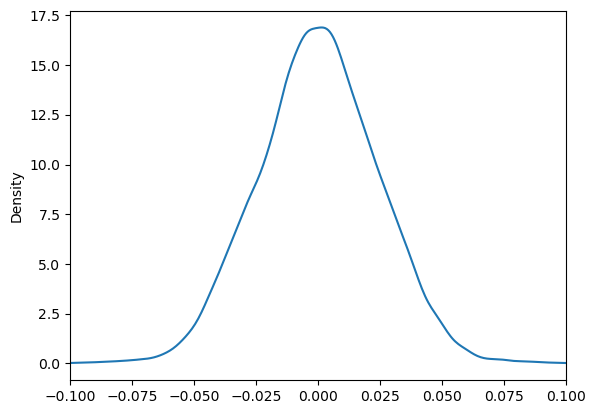

In [339]:
test['return'].diff().plot.kde(xlim=(-0.1,0.1))